In [118]:
import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import spacy

import torch
from torchtext import data
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd 
import re
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
raw_train_df = pd.read_csv("./data/train.csv")
raw_test_df = pd.read_csv("./data/test.csv")
raw_train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [40]:
del raw_train_df['keyword']
del raw_train_df['location']
del raw_train_df['id']

In [88]:
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [89]:
# Replaces the null values in the data with an empty string
train_data = raw_train_df.where((pd.notnull(raw_train_df)),'')
test_data = raw_test_df.where((pd.notnull(raw_test_df)),'')

train_data['text'] = train_data['text'].apply(text_cleaner)
test_data['text'] = test_data['text'].apply(text_cleaner)

In [80]:
# X=train_data['text'].apply(gensim.utils.simple_preprocess)
# Y = train_data['target']
# model.wv["holding"].shape
X, Y = train_data['text'], train_data['target']

In [116]:
nlp = spacy.load('en_core_web_md')
X_vector = []
pbar = tqdm.trange(X.shape[0])
for t in pbar:
    doc = nlp(X[t])
    doc_tensor = []
    for i in range(len(doc)):
        word_tensor = torch.tensor(doc[i].vector)
        doc_tensor.append(word_tensor.reshape(1,len(word_tensor)))
    X_vector.append(doc_tensor)

100%|█████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:49<00:00, 155.32it/s]


In [108]:
X_vector = np.array(X_vector)
X_train, X_test, Y_train, Y_test = train_test_split(X_vector, Y, test_size=0.2, random_state= 3)


Y_train = torch.from_numpy(Y_train.values)
Y_test = torch.from_numpy(Y_test.values)

Y_test = Y_test.view(Y_test.shape[0],1)
Y_train = Y_train.view(Y_train.shape[0],1)

print(X_train.shape, X_test.shape)

(6090,) (1523,)


In [163]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dims,  hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h_ = nn.Linear(input_size + hidden_size, hidden_dims)
        self.h_2h = nn.Linear(hidden_dims, hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_dims)
        self.h2o = nn.Linear(hidden_dims, output_size)
        self.softmax = nn.LogSoftmax(dim= 1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden1  = self.i2h_(combined)
        hidden = self.h_2h(hidden1)
        hidden2 = self.i2h(combined)
        output = self.softmax(self.h2o(hidden2))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [175]:
# we will keep feeding the RNN one row at a time 
input_size = 300
n_hidden = 300
hidden_dims = 200

n_categories = 2
num_epochs = 2
learning_rate = 0.0005
all_losses = []

rnn = RNN(input_size, hidden_dims, n_hidden, n_categories)

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

n_iters = 100000
current_loss = 0

plot_steps, print_steps = 1000, 1000

def category_from_output(output):
    category_index = torch.argmax(output).item()
    return category_index

for i in range(n_iters):
    hidden = rnn.init_hidden()
    index = random.randint(0, len(X_train) - 1)
    doc = X_train[index]
    for word_tensor in doc:
        output, hidden = rnn(word_tensor, hidden)
    loss = criterion(output, Y_train[index])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    current_loss += loss.item()
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss/ plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "Correct" if guess == Y_train[index].item() else f"Wrong ({Y_train[index].item()})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} / {guess} {correct}")

1000 1.0 1.0460 / 1 Wrong (0)
2000 2.0 1.1662 / 0 Wrong (1)
3000 3.0 1.0569 / 1 Wrong (0)
4000 4.0 0.9034 / 1 Wrong (0)
5000 5.0 0.3292 / 0 Correct
6000 6.0 0.3153 / 0 Correct
7000 7.000000000000001 0.1704 / 0 Correct
8000 8.0 0.1247 / 0 Correct
9000 9.0 0.6551 / 0 Correct
10000 10.0 0.1096 / 0 Correct
11000 11.0 0.2261 / 1 Correct
12000 12.0 0.2943 / 0 Correct
13000 13.0 0.2525 / 0 Correct
14000 14.000000000000002 1.9509 / 0 Wrong (1)
15000 15.0 0.3019 / 1 Correct
16000 16.0 0.3867 / 1 Correct
17000 17.0 0.5371 / 1 Correct
18000 18.0 0.0536 / 1 Correct
19000 19.0 0.4045 / 1 Correct
20000 20.0 0.2446 / 0 Correct
21000 21.0 1.0289 / 1 Wrong (0)
22000 22.0 0.9888 / 1 Wrong (0)
23000 23.0 0.0342 / 1 Correct
24000 24.0 0.8037 / 0 Wrong (1)
25000 25.0 0.1420 / 0 Correct
26000 26.0 0.4267 / 1 Correct
27000 27.0 0.3587 / 1 Correct
28000 28.000000000000004 0.0893 / 0 Correct
29000 28.999999999999996 0.0469 / 0 Correct
30000 30.0 0.2640 / 1 Correct
31000 31.0 0.2106 / 1 Correct
32000 32.0 0.806

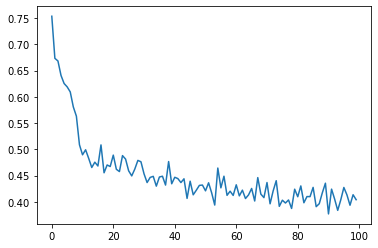

In [176]:
# print(all_losses)
plt.figure()
plt.plot(all_losses)
plt.show()

In [174]:
correct = 0
for i , doc  in enumerate(X_test):
    hidden = rnn.init_hidden()
    for word_tensor in doc:
        output, hidden = rnn(word_tensor, hidden)
    guess  = category_from_output(output)
    if guess == Y_test[i].item():
        correct += 1
print(correct/ Y_test.shape[0])

0.737360472751149
